# TensorTrade - Renderers and Plotly Visualization Chart
## Data Loading Function

In [1]:
# ipywidgets is required to run Plotly in Jupyter Notebook.
# Uncomment and run the following line to install it if required.

#!pip install ipywidgets

In [1]:
import ta

import pandas as pd

from tensortrade.feed.core import Stream, DataFeed, NameSpace
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC
from tensortrade.oms.wallets import Wallet, Portfolio

%matplotlib inline

In [2]:
def load_csv(filename):
    df = pd.read_csv('data/' + filename, skiprows=1)
    df.drop(columns=['symbol', 'volume_btc'], inplace=True)

    # Fix timestamp form "2019-10-17 09-AM" to "2019-10-17 09-00-00 AM"
    df['date'] = df['date'].str[:14] + '00-00 ' + df['date'].str[-2:]

    # Convert the date column type from string to datetime for proper sorting.
    df['date'] = pd.to_datetime(df['date'])

    # Make sure historical prices are sorted chronologically, oldest first.
    df.sort_values(by='date', ascending=True, inplace=True)

    df.reset_index(drop=True, inplace=True)

    # Format timestamps as you want them to appear on the chart buy/sell marks.
    df['date'] = df['date'].dt.strftime('%Y-%m-%d %I:%M %p')

    return df

In [3]:
df = load_csv('Bitfinex_BTCUSD_1h.csv')
df.head()

,date,open,high,low,close,volume
0,2017-07-01 11:00 AM,2505.56,2513.38,2495.12,2509.17,287000.32
1,2017-07-01 12:00 PM,2509.17,2512.87,2484.99,2488.43,393142.50
2,2017-07-01 01:00 PM,2488.43,2488.43,2454.40,2454.43,693254.01
3,2017-07-01 02:00 PM,2454.43,2473.93,2450.83,2459.35,712864.80
4,2017-07-01 03:00 PM,2459.35,2475.00,2450.00,2467.83,682105.41


## Data Preparation
### Create the dataset features

In [4]:
dataset = ta.add_all_ta_features(df, 'open', 'high', 'low', 'close', 'volume', fillna=True)
dataset.head(3)

/usr/local/anaconda3/lib/python3.7/site-packages/ta/trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
/usr/local/anaconda3/lib/python3.7/site-packages/ta/trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])


,date,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,others_dr,others_dlr,others_cr
0,2017-07-01 11:00 AM,2505.56,2513.38,2495.12,2509.17,287000.32,503274.359452,0.00,0.538883,0.000000e+00,...,-100.0,0.299976,76.944140,76.944140,-23.055860,0.0,2509.17,-65.047642,0.000000,0.000000
1,2017-07-01 12:00 PM,2509.17,2512.87,2484.99,2488.43,393142.50,-141466.449196,-393142.50,-0.207995,0.000000e+00,...,-100.0,0.371212,12.116943,44.530541,-87.883057,0.0,2488.43,-0.826568,-0.830003,-0.826568
2,2017-07-01 01:00 PM,2488.43,2488.43,2454.40,2454.43,693254.01,-988157.685450,-1086396.51,-0.606888,-2.223833e+07,...,-100.0,0.369183,0.050865,29.703982,-99.949135,0.0,2454.43,-1.366323,-1.375743,-2.181598


### Create Chart Price History Data
Note: It is recommended to create the chart data *after* creating and cleaning the dataset to ensure one-to-one mapping between the historical prices data and the dataset.

In [5]:
price_history = dataset[['date', 'open', 'high', 'low', 'close', 'volume']]  # chart data
display(price_history.head(3))

dataset.drop(columns=['date', 'open', 'high', 'low', 'close', 'volume'], inplace=True)

,date,open,high,low,close,volume
0,2017-07-01 11:00 AM,2505.56,2513.38,2495.12,2509.17,287000.32
1,2017-07-01 12:00 PM,2509.17,2512.87,2484.99,2488.43,393142.50
2,2017-07-01 01:00 PM,2488.43,2488.43,2454.40,2454.43,693254.01


## Setup Trading Environment
### Create Data Feeds

In [6]:
bitfinex = Exchange("bitfinex", service=execute_order)(
    Stream.source(price_history['close'].tolist(), dtype="float").rename("USD-BTC")
)

portfolio = Portfolio(USD, [
    Wallet(bitfinex, 10000 * USD),
    Wallet(bitfinex, 10 * BTC),
])

with NameSpace("bitfinex"):
    streams = [Stream.source(dataset[c].tolist(), dtype="float").rename(c) for c in dataset.columns]

feed = DataFeed(streams)
feed.next()

{'bitfinex:/volume_adi': 503274.35945218964,
 'bitfinex:/volume_obv': 0.0,
 'bitfinex:/volume_cmf': 0.5388828039430464,
 'bitfinex:/volume_fi': 0.0,
 'bitfinex:/volume_em': 0.0,
 'bitfinex:/volume_vpt': -187039.68188942864,
 'bitfinex:/volume_nvi': 1000.0,
 'bitfinex:/volatility_atr': 88.87448632521046,
 'bitfinex:/volatility_bbh': 2509.17,
 'bitfinex:/volatility_bbl': 2509.17,
 'bitfinex:/volatility_bbm': 2509.17,
 'bitfinex:/volatility_bbhi': 0.0,
 'bitfinex:/volatility_bbli': 0.0,
 'bitfinex:/volatility_kcc': 2505.89,
 'bitfinex:/volatility_kch': 2524.15,
 'bitfinex:/volatility_kcl': 2487.6299999999997,
 'bitfinex:/volatility_kchi': 0.0,
 'bitfinex:/volatility_kcli': 0.0,
 'bitfinex:/volatility_dch': 2509.17,
 'bitfinex:/volatility_dcl': 2509.17,
 'bitfinex:/volatility_dchi': 0.0,
 'bitfinex:/volatility_dcli': 0.0,
 'bitfinex:/trend_macd': 0.0,
 'bitfinex:/trend_macd_signal': 0.0,
 'bitfinex:/trend_macd_diff': 0.0,
 'bitfinex:/trend_ema_fast': 2509.17,
 'bitfinex:/trend_ema_slow': 2

### Trading Environment Renderers
A renderer is a channel for the trading environment to output its current state. One or more renderers can be attached to the environment at the same time. For example, you can let the environment draw a chart and log to a file at the same time.

Notice that while all renderers can technically be used together, you need to select the best combination to avoid undesired results. For example, PlotlyTradingChart can work well with FileLogger but may not display well with ScreenLogger.

Renderer can be set by name (string) or class, single or list. Available renderers are:
* `'screenlog'` or `ScreenLogger`: Shows results on the screen.
* `'filelog'` or `FileLogger`: Logs results to a file.
* `'plotly'` or `PlotlyTradingChart`: A trading chart based on Plotly.

#### Examples:

* renderers = 'screenlog' (default)
* renderers = ['screenlog', 'filelog']
* renderers = ScreenLogger()
* renderers = ['screenlog', `FileLogger()`]
* renderers = [`FileLogger(filename='example.log')`]

Renderers can also be created and configured first then attached to the environment as seen in a following example.

### Trading Environment with a Single Renderer

In [7]:
import tensortrade.env.default as default

env = default.create(
    portfolio=portfolio,
    action_scheme="managed-risk",
    reward_scheme="risk-adjusted",
    feed=feed,
    renderer="screen-log",  # ScreenLogger used with default settings
    window_size=20
)

In [8]:
from tensortrade.agents import DQNAgent

agent = DQNAgent(env)
agent.train(n_episodes=2, n_steps=200, render_interval=10)

====      AGENT ID: b8b6ad1a-c158-4743-8a2d-aab3a26ce82c      ====
[2020-07-29 3:43:06 PM] Episode: 1/2 Step: 131/200
[2020-07-29 3:43:07 PM] Episode: 1/2 Step: 141/200
[2020-07-29 3:43:08 PM] Episode: 1/2 Step: 151/200
[2020-07-29 3:43:09 PM] Episode: 1/2 Step: 161/200
[2020-07-29 3:43:11 PM] Episode: 1/2 Step: 171/200
[2020-07-29 3:43:12 PM] Episode: 1/2 Step: 181/200
[2020-07-29 3:43:13 PM] Episode: 1/2 Step: 191/200
[2020-07-29 3:43:14 PM] Episode: 1/2 Step: 201/200
[2020-07-29 3:43:15 PM] Episode: 2/2 Step: 11/200
[2020-07-29 3:43:16 PM] Episode: 2/2 Step: 21/200
[2020-07-29 3:43:17 PM] Episode: 2/2 Step: 31/200
[2020-07-29 3:43:19 PM] Episode: 2/2 Step: 41/200
[2020-07-29 3:43:20 PM] Episode: 2/2 Step: 51/200
[2020-07-29 3:43:21 PM] Episode: 2/2 Step: 61/200
[2020-07-29 3:43:22 PM] Episode: 2/2 Step: 71/200
[2020-07-29 3:43:23 PM] Episode: 2/2 Step: 81/200
[2020-07-29 3:43:24 PM] Episode: 2/2 Step: 91/200
[2020-07-29 3:43:25 PM] Episode: 2/2 Step: 101/200
[2020-07-29 3:43:26 PM] 

-125697.1219732128

### Environment with Multiple Renderers
Create PlotlyTradingChart and FileLogger renderers. Configuring renderers is optional as they can be used with their default settings.

In [9]:
from tensortrade.env.default.renderers import PlotlyTradingChart, FileLogger

chart_renderer = PlotlyTradingChart(
    display=True,  # show the chart on screen (default)
    height=800,  # affects both displayed and saved file height. None for 100% height.
    save_format="html",  # save the chart to an HTML file
    auto_open_html=True,  # open the saved HTML chart in a new browser tab
)

file_logger = FileLogger(
    filename="example.log",  # omit or None for automatic file name
    path="training_logs"  # create a new directory if doesn't exist, None for no directory
)

### Environement with Multiple Renderers

With the plotly renderer you must provide an parameter called `renderer_feed`. This is a `DataFeed` instance that provides all the information that is required by a renderer to function.

In [12]:
renderer_feed = DataFeed([
    Stream.source(price_history[c].tolist(), dtype="float").rename(c) for c in price_history]
)

env = default.create(
    portfolio=portfolio,
    action_scheme="managed-risk",
    reward_scheme="risk-adjusted",
    feed=feed,
    window_size=20,
    renderer_feed=renderer_feed,
    renderers=[
        chart_renderer, 
        file_logger
    ]
)

## Setup and Train DQN Agent
The green and red arrows shown on the chart represent buy and sell trades respectively. The head of each arrow falls at the trade execution price.

In [13]:
from tensortrade.agents import DQNAgent

agent = DQNAgent(env)

# Set render_interval to None to render at episode ends only
agent.train(n_episodes=2, n_steps=200, render_interval=10)

====      AGENT ID: fec5e2c5-eb35-4ff6-8416-b876f0e8be66      ====


-122271.41943956864

## Direct Performance and Net Worth Plotting
Alternatively, the final performance and net worth can be displayed using pandas via Matplotlib.

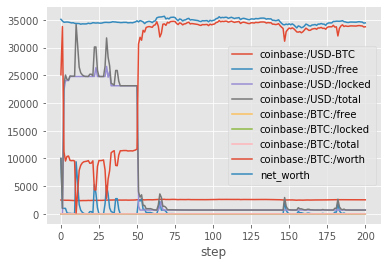

In [14]:
%matplotlib inline

performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
performance.plot()

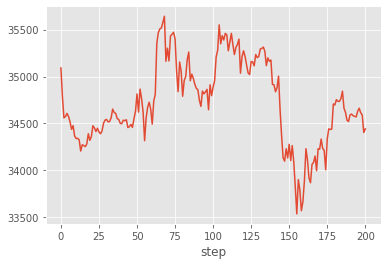

In [15]:
portfolio.performance.net_worth.plot()